In [33]:
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Altimeter Dataset

The altimeter dataset as a list of AWS-hosted NetCDF4 files is characterized by individual spatial squares of observations, over a select time span, per satelite. For example, the below block shows the first file available. Note the structure `IMOS/SRS/Surface-Waves/Wave-Wind-Altimetry-DM00/<SATELITE>/<COARSE SPATIAL TILE>/<ID with narrow spatial tile>`

```
https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/Wave-Wind-Altimetry-DM00/SENTINEL-3B/060S_300E/IMOS_SRS-Surface-Waves_MW_SENTINEL-3B_FV02_041S-300E-DM00.nc
```

## THREDDS Access
Due to the large number of files and volume, the best way to access files is through THREDDS OPeNDAP. This protocol allows you to work with the files as if they were local, while keeping them remote. It achieves this through using the file metadata, and only on calculations involving actual values will it retrieve the required data. For additional information on using THREDDS please review [Data Access Methods](https://oceanhackweek.org/ohw23/tutorials/01-Tue/Data_access_methods_Python.html?), I found it to be very helpful. 

To use please replace `https://thredds.aodn.org.au/thredds/dodsC/` prefix with `https://thredds.aodn.org.au/thredds/dodsC/` in the file URLs. 
From this point we can treat each URL as the filepath, working with them through xarray as below.

In [34]:
# Specify THREDDS file URL
filename = "https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/Wave-Wind-Altimetry-DM00/SENTINEL-3B/060S_300E/IMOS_SRS-Surface-Waves_MW_SENTINEL-3B_FV02_041S-300E-DM00.nc"

In [35]:
# Open dataset using xarray
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 375kB
Dimensions:                  (TIME: 3230)
Coordinates:
  * TIME                     (TIME) datetime64[ns] 26kB 2018-06-14T13:30:20.0...
    LATITUDE                 (TIME) float32 13kB ...
    LONGITUDE                (TIME) float32 13kB ...
Data variables: (12/24)
    BOT_DEPTH                (TIME) float32 13kB ...
    DIST2COAST               (TIME) float32 13kB ...
    SIG0_C                   (TIME) float32 13kB ...
    SIG0_C_quality_control   (TIME) float32 13kB ...
    SIG0_C_num_obs           (TIME) float32 13kB ...
    SIG0_C_std_dev           (TIME) float32 13kB ...
    ...                       ...
    SWH_KU_std_dev           (TIME) float32 13kB ...
    MEAN_WAVE_PERIOD         (TIME) float64 26kB ...
    UWND                     (TIME) float32 13kB ...
    VWND                     (TIME) float32 13kB ...
    WSPD                     (TIME) float32 13kB ...
    WSPD_CAL                 (TIME) float32 13kB ...
Attributes: (12/29)
    abstract:                      This database contains global data of wind...
    acknowledgement:               Any users of IMOS data are required to cle...
    author_email:                  agus.ribal@gmail.com
    author:                        Ribal, Agustinus
    citation:                      The citation in a list of references is: "...
    Conventions:                   CF-1.6,IMOS-1.4
    ...                            ...
    project:                       Integrated Marine Observing System (IMOS)
    source:                        RADS
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_start:           2018-06-14T13:30:20Z
    time_coverage_end:             2025-06-16T02:29:25Z
    title:                         SENTINEL-3B altimeter wave/wind data

## Altimeter Observation Visualization

In [36]:
# Access key variables
lat = ds["LATITUDE"]
lon = ds["LONGITUDE"]
swh = ds["SWH_C"]
times = ds['TIME']


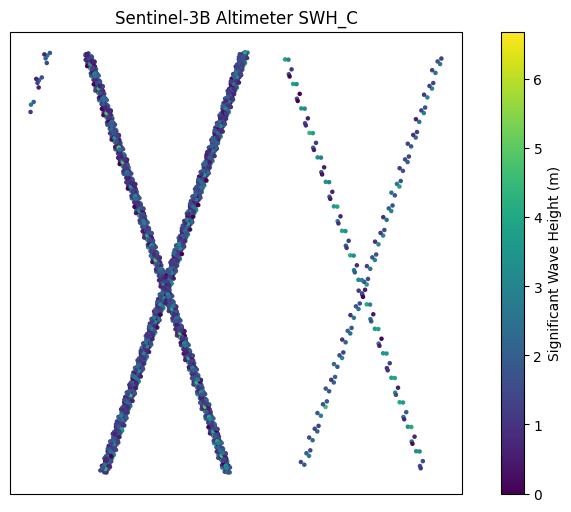

In [37]:
# Visualize altimeter ground tracks over time

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

sc = ax.scatter(
    lon,
    lat,
    c=swh,
    s=5,
    cmap="viridis",
    transform=ccrs.PlateCarree()
)

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

plt.colorbar(sc, ax=ax, label="Significant Wave Height (m)")
ax.set_title("Sentinel-3B Altimeter SWH_C")

plt.show()


## Multi-file Access

In [38]:
urls = [
    "https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/Wave-Wind-Altimetry-DM00/HY-2B/060S_200E/IMOS_SRS-Surface-Waves_MW_HY-2B_FV02_044S-212E-DM00.nc",
    "https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/Wave-Wind-Altimetry-DM00/HY-2B/020S_140E/IMOS_SRS-Surface-Waves_MW_HY-2B_FV02_005S-159E-DM00.nc",
    "https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/Wave-Wind-Altimetry-DM00/HY-2B/080S_300E/IMOS_SRS-Surface-Waves_MW_HY-2B_FV02_074S-306E-DM00.nc"
]

In [119]:
import re

# Path to your text file
url_file = "data/THREDDS_IMOS_Satellite_Remote_Sensing_-_Surface_Waves_Sub-Facility_-_altimeter_wave_wind_URLs.txt"

# WA-ish bounding box (1° tiles)
lats = [f"{d:03d}S" for d in range(14, 37)]   # 014S..036S inclusive
lons = [f"{d:03d}E" for d in range(110, 131)] # 110E..130E inclusive

pattern = re.compile(
    r"IMOS_SRS-Surface-Waves_MW_SENTINEL-3A_FV02_"
    rf"({ '|'.join(lats) })-({ '|'.join(lons) })-DM00\.nc"
)

with open(url_file, "r") as f:
    urls = [line.strip() for line in f if pattern.search(line)]

In [120]:
len(urls)

247

In [121]:
ds = xr.open_mfdataset(
    urls,
    combine="nested",
    concat_dim="TIME",
    parallel=True,
    decode_times=False
)

ds = ds.set_coords(["TIME", "LATITUDE", "LONGITUDE"])


In [122]:
ds

<xarray.Dataset> Size: 116MB
Dimensions:                  (TIME: 1003289)
Coordinates:
  * TIME                     (TIME) float64 8MB 1.139e+04 ... 1.478e+04
    LATITUDE                 (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    LONGITUDE                (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
Data variables: (12/24)
    BOT_DEPTH                (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    DIST2COAST               (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    SIG0_C                   (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    SIG0_C_quality_control   (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    SIG0_C_num_obs           (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    SIG0_C_std_dev           (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    ...                       ...
    SWH_KU_std_dev           (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    MEAN_WAVE_PERIOD         (TIME) float64 8MB dask.array<chunksize=(5438,), meta=np.ndarray>
    UWND                     (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    VWND                     (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    WSPD                     (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    WSPD_CAL                 (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
Attributes: (12/29)
    abstract:                      This database contains global data of wind...
    acknowledgement:               Any users of IMOS data are required to cle...
    author_email:                  agus.ribal@gmail.com
    author:                        Ribal, Agustinus
    citation:                      The citation in a list of references is: "...
    Conventions:                   CF-1.6,IMOS-1.4
    ...                            ...
    project:                       Integrated Marine Observing System (IMOS)
    source:                        RADS
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_start:           2016-03-05T02:22:55Z
    time_coverage_end:             2025-07-02T14:45:49Z
    title:                         SENTINEL-3A altimeter wave/wind data

In [123]:
ds.TIME

<xarray.DataArray 'TIME' (TIME: 1003289)> Size: 8MB
array([11386.099248, 11386.099259, 11386.099271, ..., 14775.054479,
       14775.054491, 14775.054514], shape=(1003289,))
Coordinates:
  * TIME       (TIME) float64 8MB 1.139e+04 1.139e+04 ... 1.478e+04 1.478e+04
    LATITUDE   (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
    LONGITUDE  (TIME) float32 4MB dask.array<chunksize=(5438,), meta=np.ndarray>
Attributes:
    long_name:      time
    standard_name:  time
    units:          days since 1985-01-01 00:00:00 UTC
    axis:           T
    calendar:       gregorian
    valid_max:      1.7976931348623157e+308
    valid_min:      2.2250738585072014e-308

In [124]:
# Filter by time
ds = xr.decode_cf(ds)

In [129]:
ds_sorted = ds.sortby("TIME")

In [131]:
ds_jan2018 = ds_sorted.sel(TIME=slice("2019-01-01", "2019-02-01"))

In [132]:
ds_jan2018

<xarray.Dataset> Size: 1MB
Dimensions:                  (TIME: 8956)
Coordinates:
  * TIME                     (TIME) datetime64[ns] 72kB 2019-01-01T01:24:59.0...
    LATITUDE                 (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    LONGITUDE                (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
Data variables: (12/24)
    BOT_DEPTH                (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    DIST2COAST               (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    SIG0_C                   (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    SIG0_C_quality_control   (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    SIG0_C_num_obs           (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    SIG0_C_std_dev           (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    ...                       ...
    SWH_KU_std_dev           (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    MEAN_WAVE_PERIOD         (TIME) float64 72kB dask.array<chunksize=(409,), meta=np.ndarray>
    UWND                     (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    VWND                     (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    WSPD                     (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
    WSPD_CAL                 (TIME) float32 36kB dask.array<chunksize=(409,), meta=np.ndarray>
Attributes: (12/29)
    abstract:                      This database contains global data of wind...
    acknowledgement:               Any users of IMOS data are required to cle...
    author_email:                  agus.ribal@gmail.com
    author:                        Ribal, Agustinus
    citation:                      The citation in a list of references is: "...
    Conventions:                   CF-1.6,IMOS-1.4
    ...                            ...
    project:                       Integrated Marine Observing System (IMOS)
    source:                        RADS
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_start:           2016-03-05T02:22:55Z
    time_coverage_end:             2025-07-02T14:45:49Z
    title:                         SENTINEL-3A altimeter wave/wind data

In [133]:
lon = ds_jan2018["LONGITUDE"].values
lat = ds_jan2018["LATITUDE"].values
swh = ds_jan2018["SWH_C"].values   # use your actual SWH variable name


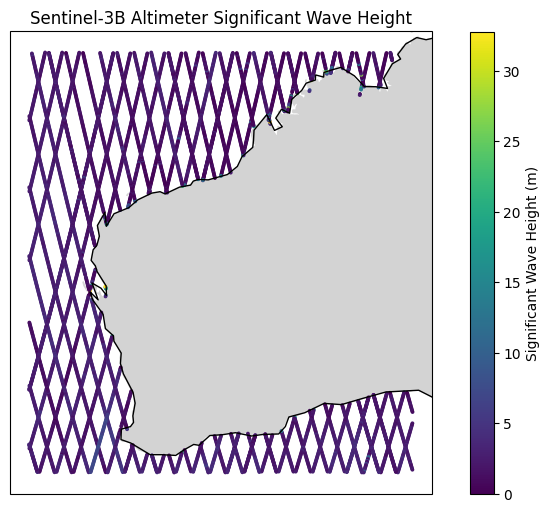

In [134]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

sc = ax.scatter(
    lon,
    lat,
    c=swh,
    s=3,                     # smaller points for dense tracks
    cmap="viridis",
    transform=ccrs.PlateCarree()
)

ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

plt.colorbar(sc, ax=ax, label="Significant Wave Height (m)")
ax.set_title("Sentinel-3B Altimeter Significant Wave Height")

plt.show()


## Thoughts on Time-based Full Dataset Access for Deep Learning

For deep-learning applications such as interpolation or data assimilation, time-based applications (i.e. retrieving the previous 48 hr observations) are critical. The current spatial-tile format of the altimeter observations lends efficiency to spatial applications. The idea is to adjust the observations into a global 1D time-ordered point-cloud format per mission for rolling-time deep learning applications

To adapt the file format, an idea is to sequentially download each spatial tile for a single mission. For each spatial tile, seperate observations by day, and write files to a temporary cache (parallelism works well when writing seperate files). Then reduce over the daily files into a single immutable monthly Zarr file (chunked by day). This structure works well for parallel data loaders, due to the small slices required out of the total archive for batches. 

Example temporary files:
```
tmp/
  tile=020S_080E/
    day=2018-01-01.zarr
    day=2018-01-02.zarr
```

Example mission file structure:
```
final/
  mission=SENTINEL-3A/
    day=2018-01-01.zarr
    day=2018-01-02.zarr
```

This still needs refinement and practical tests to see if it would work well.
